# Exploratory Analysis — Pindamonhangaba Climate Data (1940–2025)

> **Purpose**: Quick sanity checks and visual exploration of the raw merged CSV before processing.
>
> **Input**: `data/raw/pindamonhangaba_1940_2025.csv` (produced by `fetch_climate_data.py`)
>
> Run cells in order. Requires: `pandas`, `numpy`, `matplotlib`, `seaborn`, `scipy`.

In [1]:
# ── Cell 1: Load raw CSV, display .head(), .info(), .describe() ──────────────

from pathlib import Path

import numpy as np
import pandas as pd

# Resolve path relative to this notebook's location
NOTEBOOK_DIR = Path(".").resolve()
RAW_CSV = NOTEBOOK_DIR.parent / "raw" / "pindamonhangaba_1940_2025.csv"

if not RAW_CSV.exists():
    raise FileNotFoundError(
        f"Raw CSV not found at {RAW_CSV}.\n"
        "Run `python data/scripts/fetch_climate_data.py` first."
    )

df = pd.read_csv(RAW_CSV, parse_dates=["date"])

print(f"Shape: {df.shape}")
print(f"Date range: {df['date'].min().date()} → {df['date'].max().date()}")
print(f"Expected rows (1940-01-01 to 2025-12-31): {(pd.Timestamp('2025-12-31') - pd.Timestamp('1940-01-01')).days + 1}")
print()

print("── head() ──────────────────────────────────────────────")
display(df.head(10))

print("\n── info() ──────────────────────────────────────────────")
df.info()

print("\n── describe() ──────────────────────────────────────────")
display(df.describe().round(2))

Shape: (31412, 7)
Date range: 1940-01-01 → 2025-12-31
Expected rows (1940-01-01 to 2025-12-31): 31412

── head() ──────────────────────────────────────────────


,date,temp_max,temp_min,temp_mean,precipitation,humidity,wind_max
0,1940-01-01,24.9,17.9,20.8,NaN,90,9.4
1,1940-01-02,25.8,19.2,22.6,5.0,81,10.4
2,1940-01-03,27.3,19.4,22.9,7.2,82,11.4
3,1940-01-04,25.7,19.0,22.6,8.0,84,14.0
4,1940-01-05,25.7,19.8,22.1,23.1,91,9.7
5,1940-01-06,27.5,19.1,22.8,25.3,89,9.7
6,1940-01-07,27.6,20.0,22.9,16.9,86,8.9
7,1940-01-08,27.0,19.4,22.1,28.9,89,9.7
8,1940-01-09,25.6,19.6,22.1,19.4,91,7.6
9,1940-01-10,24.2,20.2,21.6,26.3,93,7.6



── info() ──────────────────────────────────────────────
<class 'pandas.DataFrame'>
RangeIndex: 31412 entries, 0 to 31411
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           31412 non-null  datetime64[us]
 1   temp_max       31412 non-null  float64       
 2   temp_min       31412 non-null  float64       
 3   temp_mean      31412 non-null  float64       
 4   precipitation  31411 non-null  float64       
 5   humidity       31412 non-null  int64         
 6   wind_max       31412 non-null  float64       
dtypes: datetime64[us](1), float64(5), int64(1)
memory usage: 1.7 MB

── describe() ──────────────────────────────────────────


,date,temp_max,temp_min,temp_mean,precipitation,humidity,wind_max
count,31412,31412.00,31412.00,31412.00,31411.00,31412.00,31412.00
mean,1982-12-31 12:00:00,25.79,16.04,20.54,4.37,78.20,9.49
min,1940-01-01 00:00:00,9.40,1.30,8.00,0.00,29.00,3.40
25%,1961-07-01 18:00:00,23.50,13.70,18.40,0.00,73.00,7.30
50%,1982-12-31 12:00:00,26.00,16.60,20.80,0.70,79.00,8.90
75%,2004-07-01 06:00:00,28.40,18.70,22.80,5.70,85.00,11.10
max,2025-12-31 00:00:00,38.20,24.70,30.50,153.60,98.00,27.80
std,NaN,3.66,3.28,3.04,7.64,9.12,2.95


Total NaN values across all columns: 1
Missing per column:
temp_max         0
temp_min         0
temp_mean        0
precipitation    1
humidity         0
wind_max         0


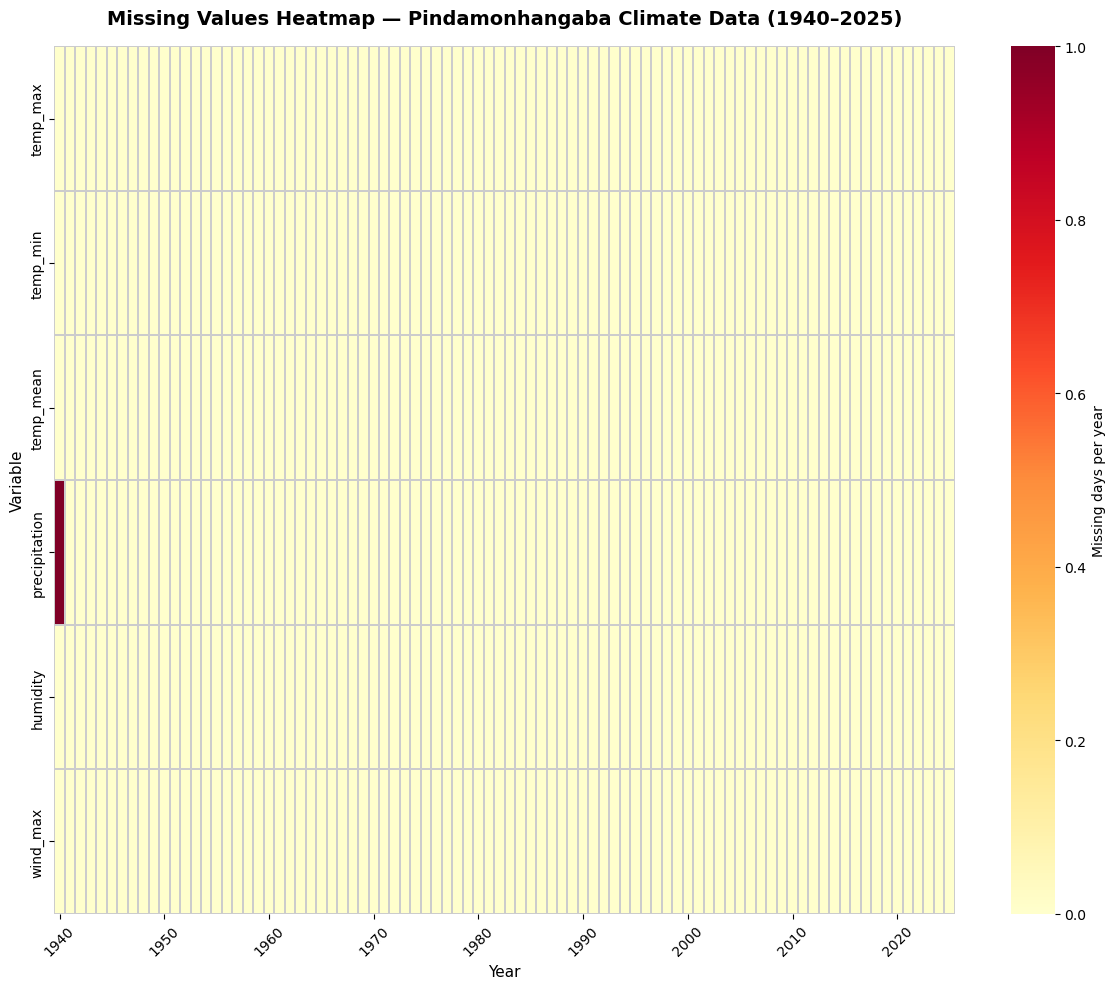

Saved → missing_values_heatmap.png


In [2]:
# ── Cell 2: Missing values heatmap (seaborn) ──────────────────────────────────
#
# Strategy: pivot the boolean NaN mask to a (year × month) grid per column,
# then show a heatmap of the fraction of missing days per year-month.
# This makes it easy to spot systematic gaps (e.g., entire months missing).

import matplotlib.pyplot as plt
import seaborn as sns

# Add helper columns
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

COLS = ["temp_max", "temp_min", "temp_mean", "precipitation", "humidity", "wind_max"]

# Build a (year × variable) missing-count matrix
missing_by_year = (
    df.set_index("date")[COLS]
    .isnull()
    .resample("YE")  # resample to year-end
    .sum()
    .astype(int)
)
missing_by_year.index = missing_by_year.index.year  # use integer year labels

total_missing = missing_by_year.values.sum()
print(f"Total NaN values across all columns: {total_missing}")
print(f"Missing per column:\n{df[COLS].isnull().sum().to_string()}")

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    missing_by_year.T,
    ax=ax,
    cmap="YlOrRd",
    linewidths=0.3,
    linecolor="#cccccc",
    annot=False,
    cbar_kws={"label": "Missing days per year"},
    xticklabels=10,  # show every 10th year to avoid crowding
)

ax.set_title(
    "Missing Values Heatmap — Pindamonhangaba Climate Data (1940–2025)",
    fontsize=14, fontweight="bold", pad=16,
)
ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("Variable", fontsize=11)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig(NOTEBOOK_DIR / "missing_values_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved → missing_values_heatmap.png")

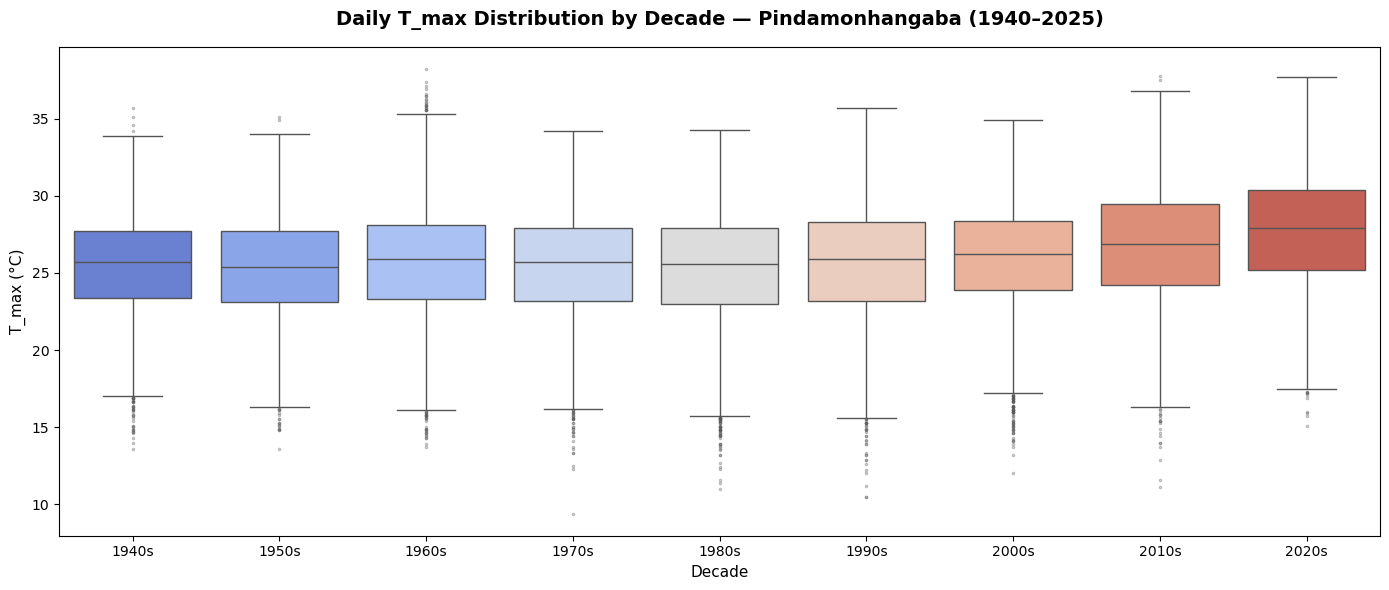

Saved → tmax_boxplot_by_decade.png


In [3]:
# ── Cell 3: T_max boxplot by decade ──────────────────────────────────────────
#
# Shows how the distribution of daily T_max has shifted across decades.
# Uses hue= to avoid the seaborn 0.14 FutureWarning about palette without hue.

import matplotlib.pyplot as plt
import seaborn as sns

# Create decade label
df["decade"] = (df["year"] // 10 * 10).astype(str) + "s"

# Palette: one colour per decade (cool → warm)
decades = sorted(df["decade"].unique())
palette = sns.color_palette("coolwarm", n_colors=len(decades))

fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(
    data=df,
    x="decade",
    y="temp_max",
    hue="decade",          # assign x-variable to hue …
    palette=palette,
    order=decades,
    hue_order=decades,
    legend=False,          # … but hide the redundant legend
    ax=ax,
    flierprops=dict(marker=".", markersize=3, alpha=0.4),
)

ax.set_title(
    "Daily T_max Distribution by Decade — Pindamonhangaba (1940–2025)",
    fontsize=14, fontweight="bold", pad=16,
)
ax.set_xlabel("Decade", fontsize=11)
ax.set_ylabel("T_max (°C)", fontsize=11)
ax.tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.savefig(NOTEBOOK_DIR / "tmax_boxplot_by_decade.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved → tmax_boxplot_by_decade.png")

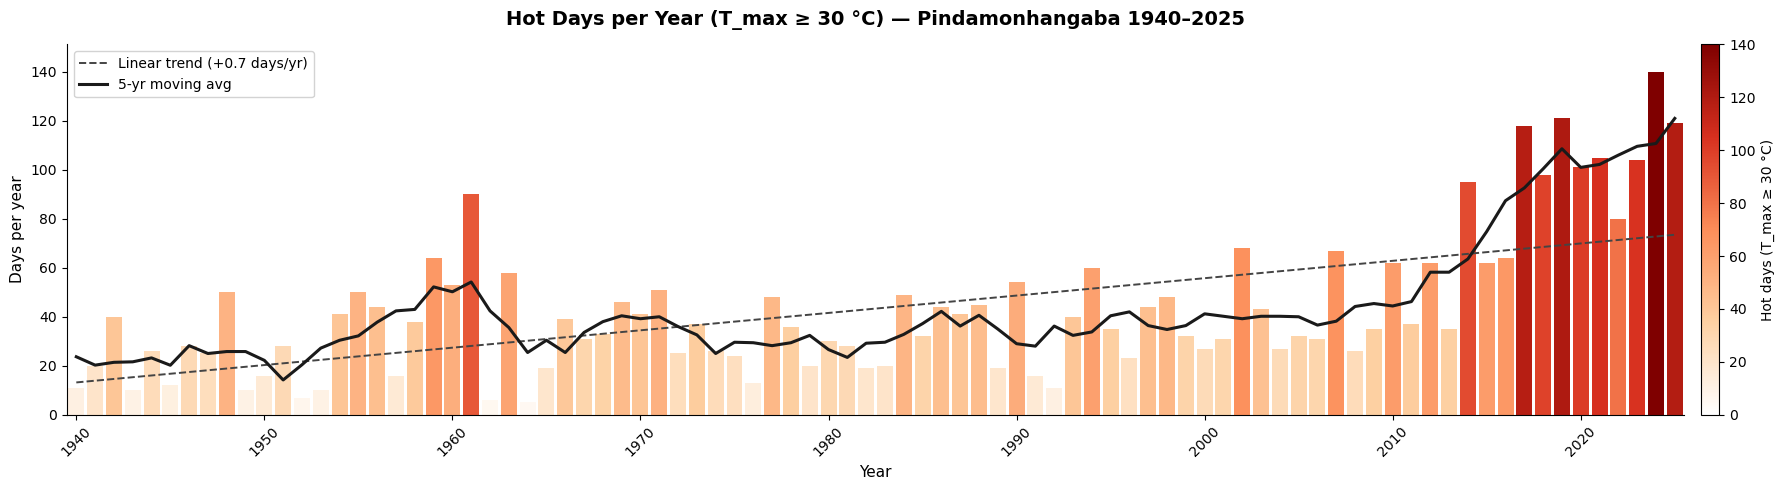

Saved → hd30_per_year.png


In [4]:
# ── Cell 4: Hot days per year (HD30) — bars coloured by count + 5-yr MA + linear trend —————─
#
# Definition: HD30 = days per year with T_max >= 30 °C.
#
# Two overlay lines:
#   • Dashed grey   →  Linear trend (OLS)  — answers "net direction over 86 years"
#   • Solid dark     →  5-year moving avg   — reveals decade-scale acceleration/plateaus

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

HD30_THRESHOLD = 30.0  # °C

# Count HD30 per year (drop years with all-NaN temp_max)
hd30 = (
    df[df["temp_max"].notna()]
    .groupby("year")["temp_max"]
    .apply(lambda s: (s >= HD30_THRESHOLD).sum())
    .rename("hd30")
    .reset_index()
)

# ── colour map: white → deep red, driven by hd30 count ─────────────────────────────
cmap = mcolors.LinearSegmentedColormap.from_list(
    "hd30_ramp",
    ["#ffffff", "#fdd0a2", "#fc8d59", "#d7301f", "#7f0000"],
)

vmin, vmax = 0, hd30["hd30"].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
bar_colours = [cmap(norm(v)) for v in hd30["hd30"]]

# ── 5-year centred moving average ─────────────────────────────────────────────────
ma5 = hd30["hd30"].rolling(window=5, center=True, min_periods=3).mean()

# ── linear trend (OLS) ──────────────────────────────────────────────────────────────
m, b = np.polyfit(hd30["year"], hd30["hd30"], 1)
trend_y = m * hd30["year"] + b

# ── plot ─────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(18, 5))

bars = ax.bar(
    hd30["year"],
    hd30["hd30"],
    color=bar_colours,
    width=0.85,
    edgecolor="none",
)

# Linear trend line (dashed, grey)
ax.plot(
    hd30["year"],
    trend_y,
    color="#444444",
    linewidth=1.4,
    linestyle="--",
    label=f"Linear trend ({m:+.1f} days/yr)",
    zorder=3,
)

# 5-year moving average line (solid, dark)
ax.plot(
    hd30["year"],
    ma5,
    color="#1a1a1a",
    linewidth=2.2,
    linestyle="-",
    label="5-yr moving avg",
    zorder=4,
)

ax.legend(fontsize=10, loc="upper left", framealpha=0.85)

# Colour-bar legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.01, fraction=0.015)
cbar.set_label("Hot days (T_max ≥ 30 °C)", fontsize=10)

ax.set_title(
    "Hot Days per Year (T_max ≥ 30 °C) — Pindamonhangaba 1940–2025",
    fontsize=14, fontweight="bold", pad=14,
)
ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("Days per year", fontsize=11)
ax.set_xlim(hd30["year"].min() - 0.5, hd30["year"].max() + 0.5)
ax.set_ylim(0, vmax * 1.08)
ax.tick_params(axis="x", rotation=45)
ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.savefig(NOTEBOOK_DIR / "hd30_per_year.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved → hd30_per_year.png")


In [5]:
# ── Cell 5: Integrity checks ─────────────────────────────────────────────────
#   • No T_min > T_max violations
#   • No out-of-range values (T_max < 50 °C, T_min > -10 °C)

inv = df[df["temp_min"] > df["temp_max"]]
print(f"T_min > T_max violations : {len(inv)}")
if not inv.empty:
    display(inv[["date", "temp_min", "temp_max"]].head(10))

out_tmax = df[df["temp_max"] >= 50]
print(f"T_max >= 50 °C           : {len(out_tmax)}")

out_tmin = df[df["temp_min"] <= -10]
print(f"T_min <= -10 °C          : {len(out_tmin)}")

neg_precip = df[df["precipitation"] < 0]
print(f"Precipitation < 0        : {len(neg_precip)}")

print("\nAll checks passed ✓" if (len(inv) == 0 and len(out_tmax) == 0
                                  and len(out_tmin) == 0 and len(neg_precip) == 0)
      else "\nSome checks FAILED — review output above.")

T_min > T_max violations : 0
T_max >= 50 °C           : 0
T_min <= -10 °C          : 0
Precipitation < 0        : 0

All checks passed ✓
